### Load Packages

In [1]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
sys.path.append('../')

In [2]:
aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300, # corresponding to 10^8 copies / mL
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}


class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': 0.851,
    'sensitivity': 0.6
}

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0


def exists_pos_in_class(frac_vax, N, params = class_risk_params):
    num_vax = np.floor(N*frac_vax)
    num_unvax = N-num_vax

    prev_unvax = params['prevalence']
    prev_vax = prev_unvax * (1-params['vax_effectiveness'])

    p_pos_unvax = prev_unvax * (1-params['sensitivity'])
    p_pos_vax = prev_vax * (1-params['sensitivity'])

    prob_exists_positive = 1 - (1-p_pos_unvax)**num_unvax * (1-p_pos_vax)**num_vax
    prob_one_positive = num_unvax * p_pos_unvax * (1-p_pos_unvax)**(num_unvax-1) * (1-p_pos_vax)**num_vax + \
                      (1-p_pos_unvax)**num_unvax * num_vax * p_pos_vax * (1-p_pos_vax)**(num_vax-1)
    approx_error = prob_exists_positive - prob_one_positive

    return prob_exists_positive, prob_one_positive, approx_error*N

def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time, function,alpha,masked_status,frac_vax,room_vol,N):
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    aerosol_risk = 0.5*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, frac_vax, params = aerosol_params)
    p_exist = exists_pos_in_class(frac_vax, N, params = class_risk_params)[0]
    
    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        if theta < 90 + alpha:
       
            susceptible_status = row['seating']
            dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
            p = function(dist,susceptible_status,source_status,masked_status,time)
            p = max(p,aerosol_risk)
            p_infections.append(p)
        else:
            p_infections.append(aerosol_risk)
            
    return np.sum(p_infections)*p_exist

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time): 
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const = 1
    if susceptible_status == 'V':
        susceptible_const = 0.25
    if source_status == 'V':
        source_const = 0.25
    if masked_status == True:
        masked_const = 0.8

    prob = susceptible_const*(1-np.exp(-1 * source_const* masked_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, frac_vax, params = aerosol_params):

    v = params['nominal_breathe_virus_emitted_hourly'] 
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])

  # variables: source vaccinated? susceptible vaccinated? susceptible masked?
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    if masked_status == 1:
        dose_array = dose_array * 0.8
    if vax_infected == 1:
        dose_array = dose_array * 0.25
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)
    vax_susceptible_risk_array = 0.25 * unvax_susceptible_risk_array
    
    susceptible_risk_array = unvax_susceptible_risk_array * (1-frac_vax) + vax_susceptible_risk_array * frac_vax

    susceptible_risk = np.dot(susceptible_risk_array, np.array(params['viral_load_distribution']))

    individual_susceptible_risk_over_time = susceptible_risk * time

    return individual_susceptible_risk_over_time





In [16]:
def generate_clumpy_plan(N,p,room, clump_size):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Room Configurations

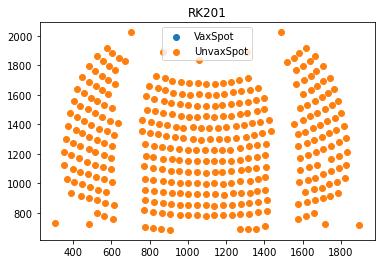

In [17]:
with open("../Data/rk201.pickle" , 'rb') as handle:
    results_1feet = pickle.load(handle)
    
pixels_per_foot = (2074-1575)/20
total_seats = 371
layouts = [results_1feet]

rooms = []
unvax_prop = []
i = 0
for layout in layouts:
    ft = 1
    x_coord = [i.x for i in layout['Middles']]
    y_coord = [i.y for i in layout['Middles']]
    room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
    room['UnvaxSpot'] = layout['In Solution']
    room['feet_apart'] = ft
    unvax_prop.append(sum(room['UnvaxSpot'])/len(room))
    rooms.append(room)
    plt.figure()
    plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'], label = 'VaxSpot')
    plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'UnvaxSpot')
    plt.title('RK201')
    plt.legend()
    i = i + 1 

# Recreate Fall 2020 layout

Fall 2020 Capacity: 56


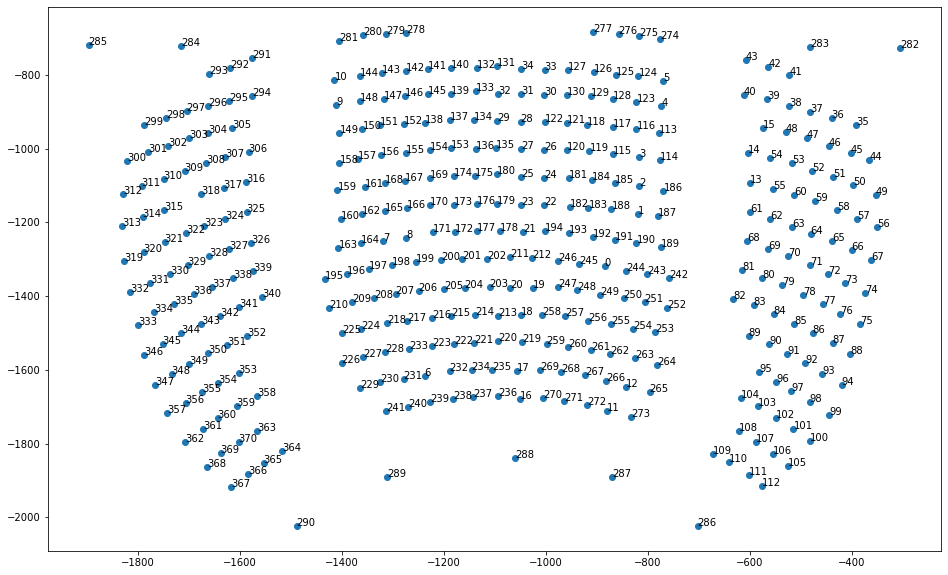

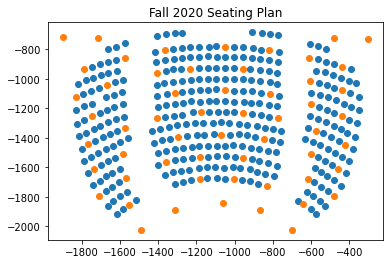

In [18]:
FA2020room = rooms[0].copy()
FA2020room['label'] = FA2020room.index

#Set label_seats = TRUE to hand label which seats were used in 2020
label_seats = True
if label_seats == True:
    fig, ax = plt.subplots(figsize=(16,10))
    ax.scatter(-FA2020room['x'],-FA2020room['y'])
    for i, txt in enumerate(FA2020room['label'].values):
        ax.annotate(txt, (-FA2020room['x'][i],-FA2020room['y'][i]))
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(-FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],-FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(-FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],-FA2020room[FA2020room['UnvaxSpot'] == 1]['y'])
plt.title('Fall 2020 Seating Plan')
print('Fall 2020 Capacity: ' + str(len(indicies)))

V    30
E    18
U     8
Name: seating, dtype: int64


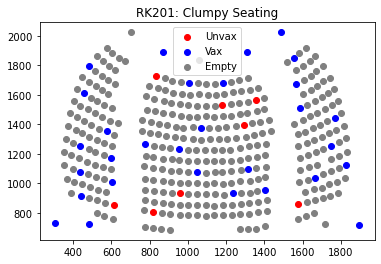

In [19]:
FA2020room_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
FA2020room_subset
grid = generate_clumpy_plan(38,.8,FA2020room_subset,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')


plt.title('RK201: '+ 'Clumpy Seating')
plt.legend()
print(grid['seating'].value_counts())

### Clumpy Experiment

In [33]:
%%time
aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300, # corresponding to 10^8 copies / mL
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}


results = []
p_range = np.arange(0,1.1,.1)
N = 38
time = 12
masking = True
room_vol = 1684283 
room = FA2020room_subset
for p in p_range:
    print(p)
    trial = 0
    while trial < 100:
        grid = generate_clumpy_plan(N,p,room,3)
        prop_vax = p 
        p_generate = prop_vax /(4-3*prop_vax)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        infect = simulate_class_single_aerosol(grid,ind, 1-ind, time, updated_distance_to_prob,15,masking,p,room_vol,N)
        results.append([p,infect])
        trial = trial + 1
results = pd.DataFrame(results,columns = ['p','infections'])

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
Wall time: 5min 56s


In [31]:
masked_results = results.copy()


In [32]:
aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300, # corresponding to 10^8 copies / mL
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}


results = []
p_range = np.arange(0,1.1,.1)
N = 38
time = 12
masking = False
room_vol = 1684283 
room = FA2020room_subset
for p in p_range:
    print(p)
    trial = 0
    while trial < 1000:
        grid = generate_clumpy_plan(N,p,room,3)
        prop_vax = p 
        p_generate = prop_vax /(4-3*prop_vax)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        infect = simulate_class_single_aerosol(grid,ind, 1-ind, time, updated_distance_to_prob,15,masking,p,room_vol,N)
        results.append([p,infect])
        trial = trial + 1
results = pd.DataFrame(results,columns = ['p','infections'])

0.0
0.1
0.2
0.30000000000000004


KeyboardInterrupt: 

In [27]:
unmaksed_results = results.copy()

In [28]:
masked_toplot = masked_results.groupby('p').infections.agg(['mean','std']).reset_index()
unmasked_toplot = unmaksed_results.groupby('p').infections.agg(['mean','std']).reset_index()

Text(0.5, 1.0, 'Summer Session: Rockefeller 201')

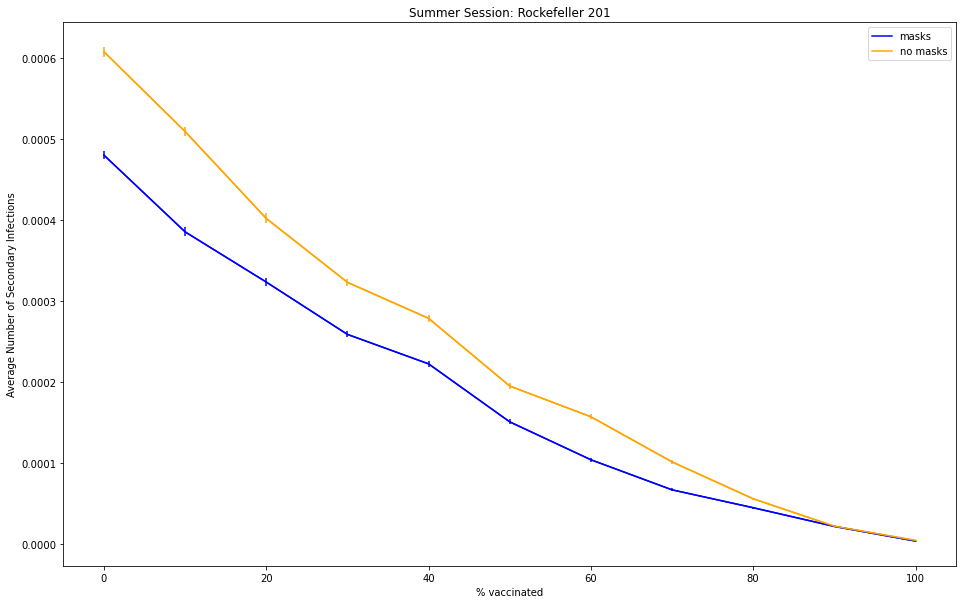

In [29]:
plt.figure(figsize = (16,10))
plt.plot(100*masked_toplot['p'],masked_toplot['mean'], label = 'masks', color = 'blue')
plt.errorbar(100*masked_toplot['p'],masked_toplot['mean'], yerr = masked_toplot['std']/math.sqrt(1000), color = 'blue')


plt.plot(100*unmasked_toplot['p'],unmasked_toplot['mean'], label = 'no masks', color = 'orange')
plt.errorbar(100*unmasked_toplot['p'],unmasked_toplot['mean'], yerr = unmasked_toplot['std']/math.sqrt(1000), color = 'orange')
plt.legend()
plt.xlabel('% vaccinated')

plt.ylabel('Average Number of Secondary Infections')
plt.title('Summer Session: Rockefeller 201')